In [215]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/features_and_labels_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']

In [4]:
# take the feature labels out of a root file
with uproot.open(f"root_files/ntuple_merged_0.root:deepntuplizer/tree") as tree:
    features = ['fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 

# 2 labels: QCD or Hbb. Logical "and" of labels is used.
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nlabels = len(labels)

In [5]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [6]:
with np.load("root_files/features_and_labels_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [7]:
del feature_array, label_array

In [8]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [9]:
del feature_array_test, label_array_test

In [10]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [11]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(13234082, 31)
(13234082, 31)
(1467277, 31)
(1467277, 31)


In [12]:
del bkg, sig, bkg_test, sig_test, df

In [13]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [14]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(2010784, 31)
(2010784, 31)
(222732, 31)
(222732, 31)


  0%|          | 0/30 [00:00<?, ?it/s]

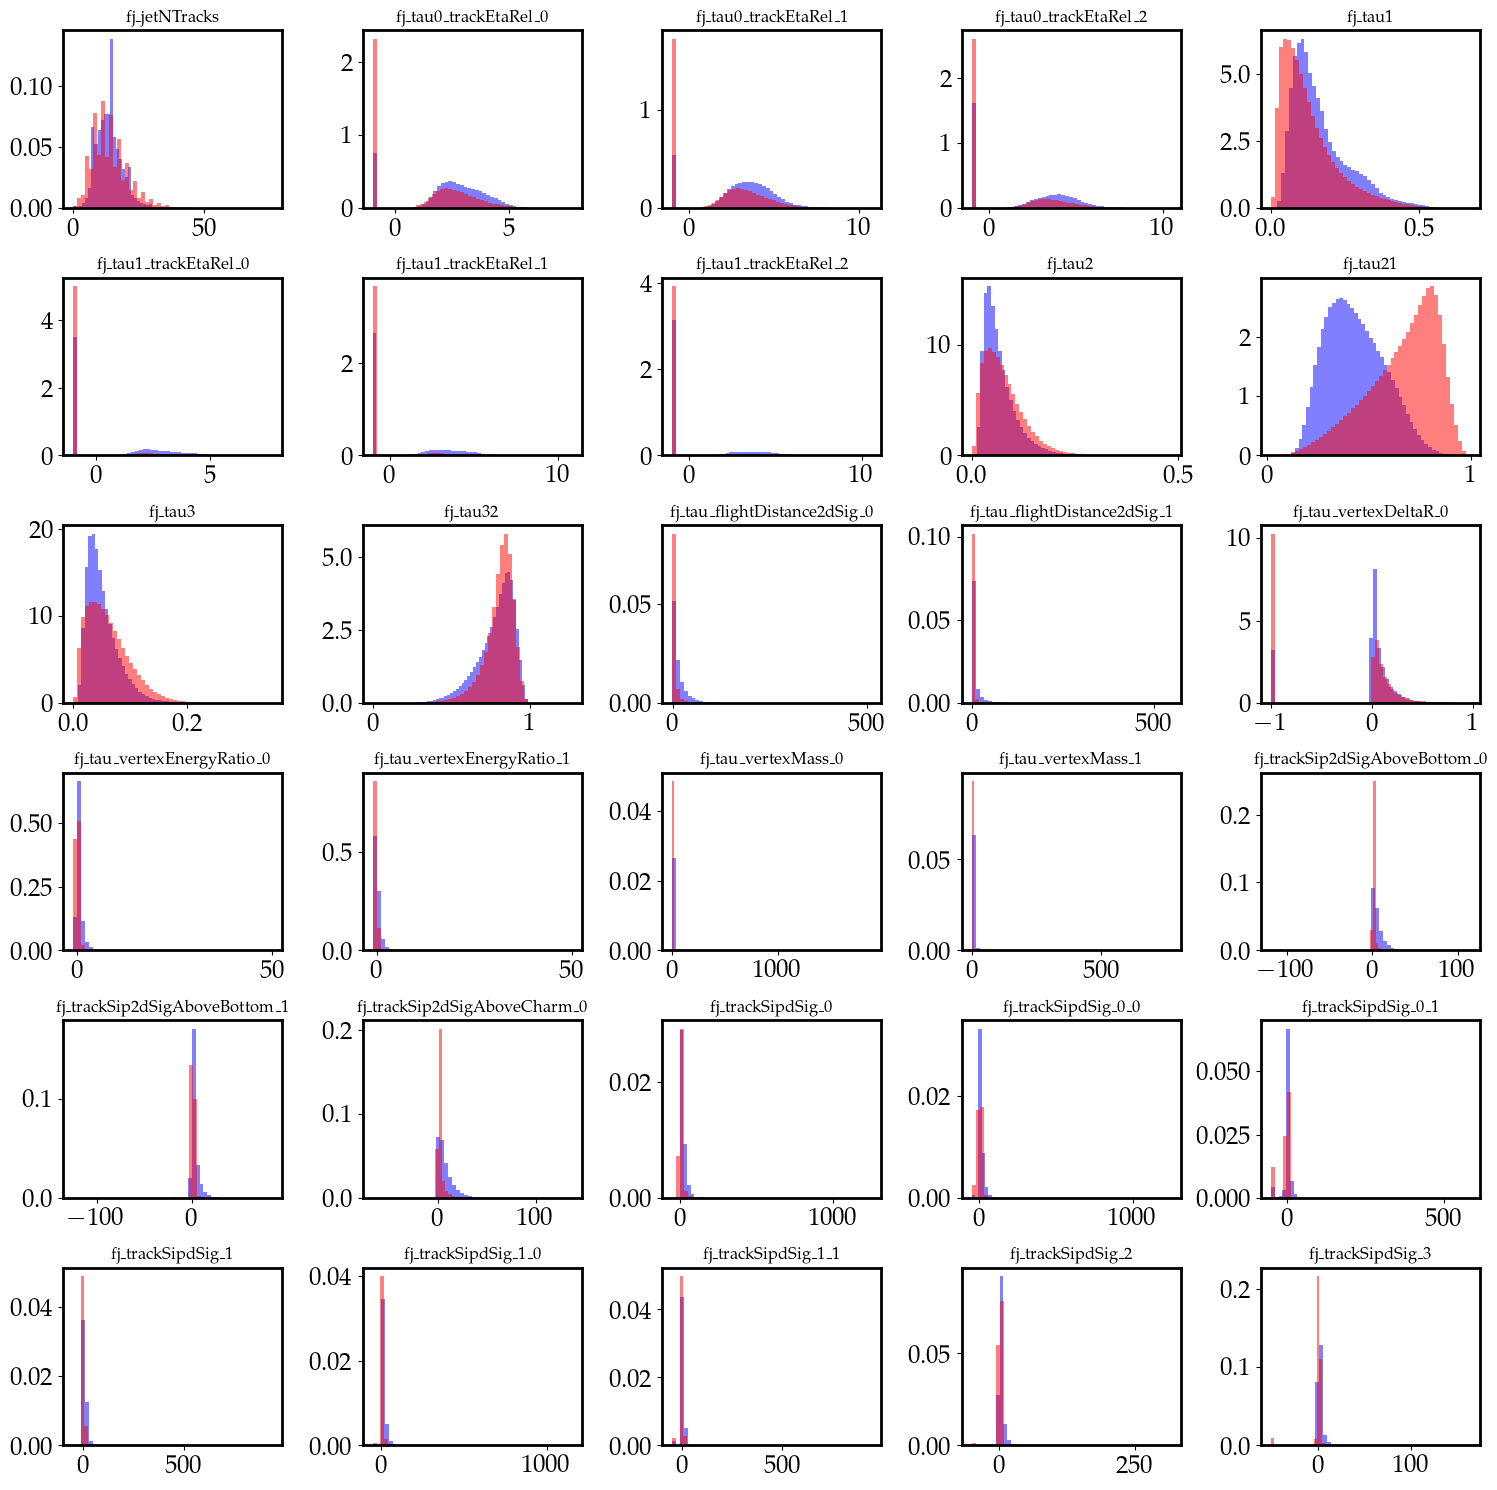

In [16]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in tqdm(zip(axes.ravel(), sig_train_out.columns.drop('fj_nSV')), total = 30):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

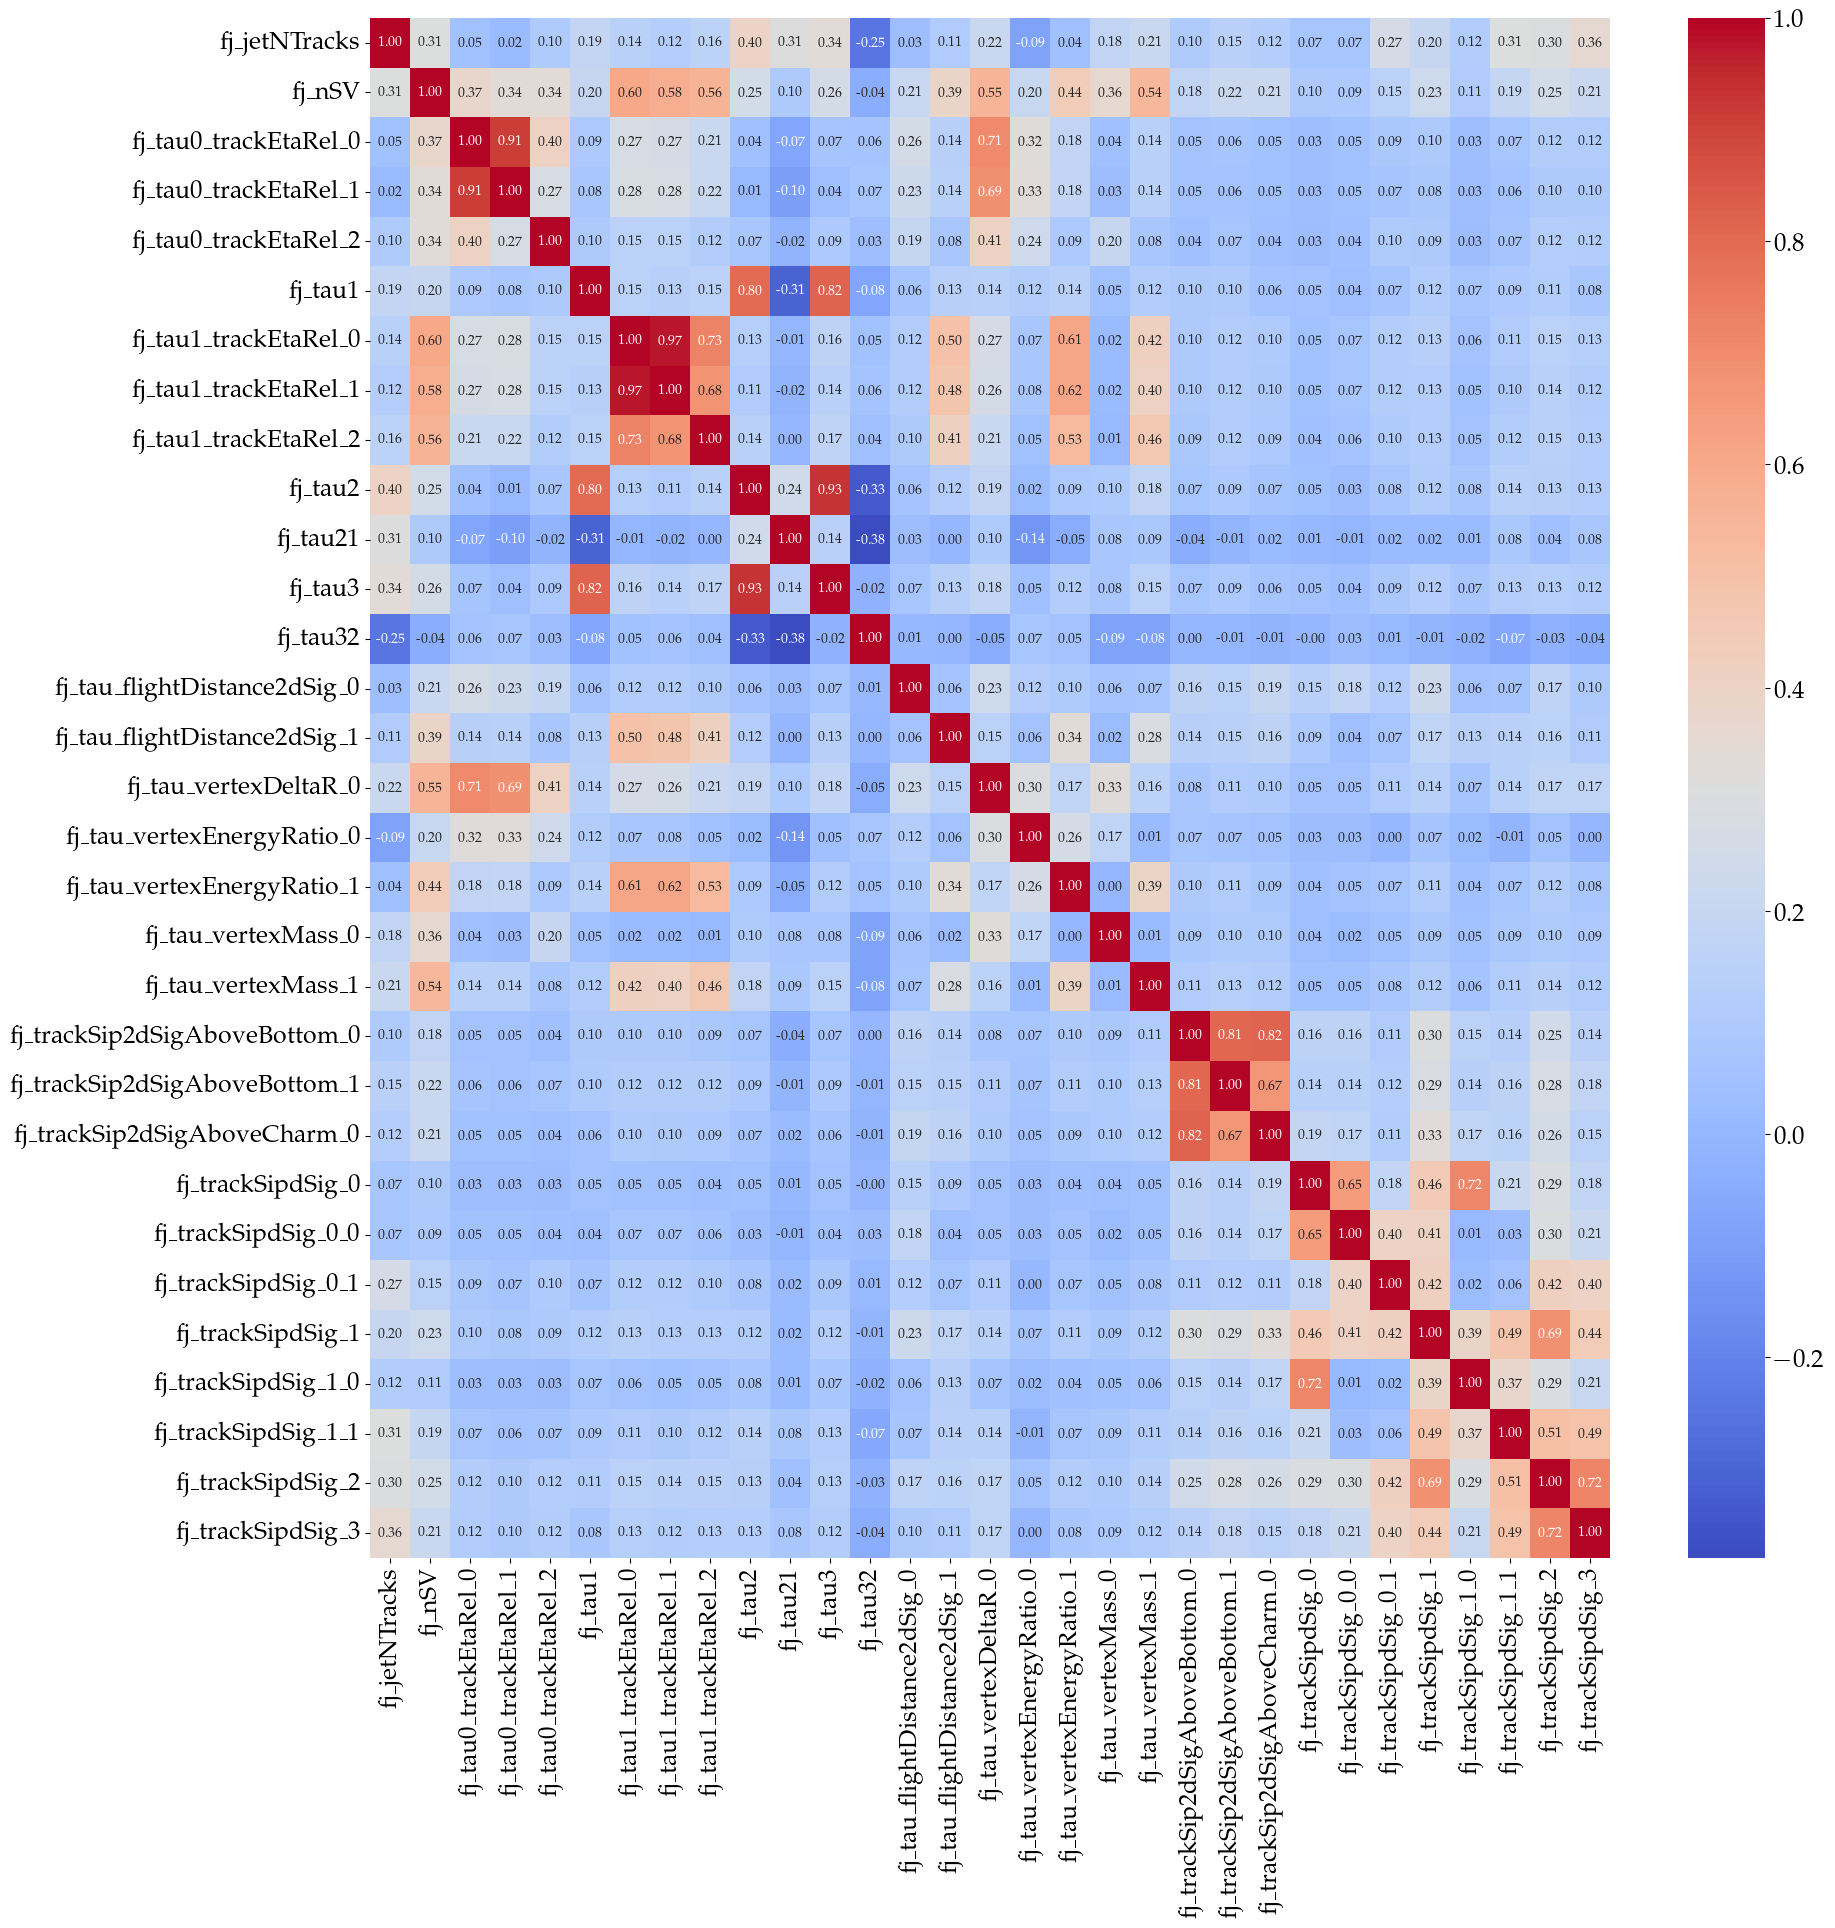

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

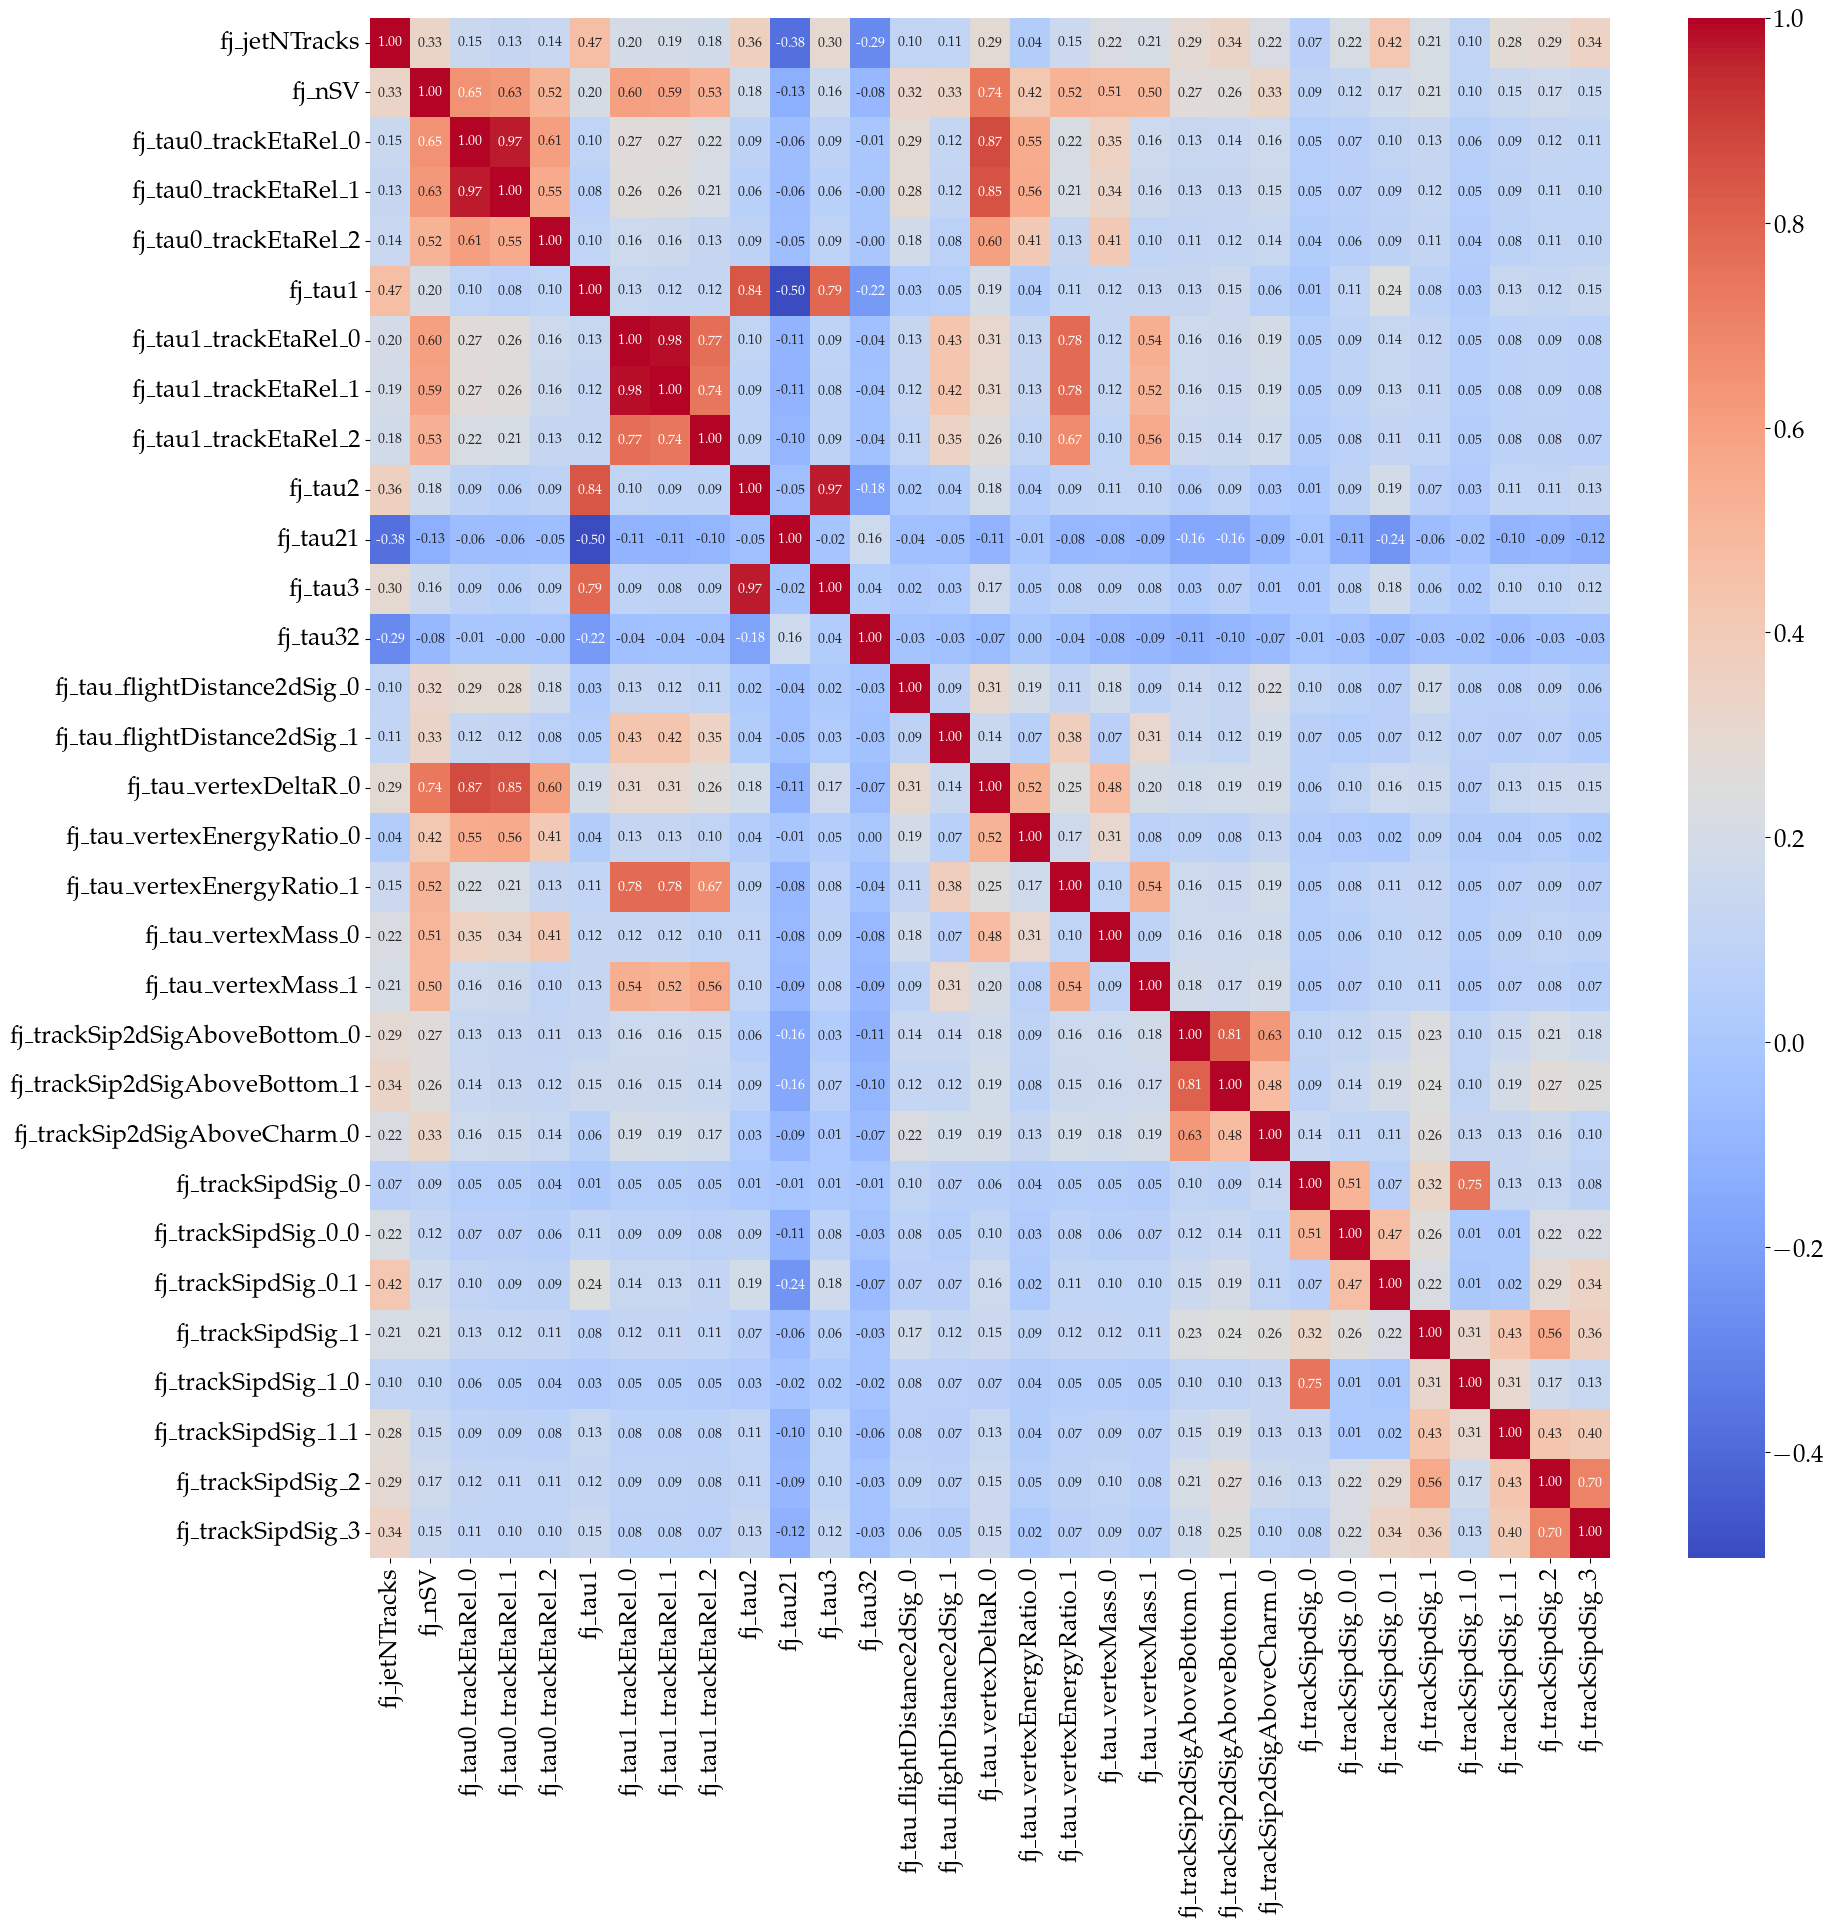

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

In [19]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [20]:
del traindata

In [21]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [22]:
del testdata

In [23]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

In [24]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [25]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

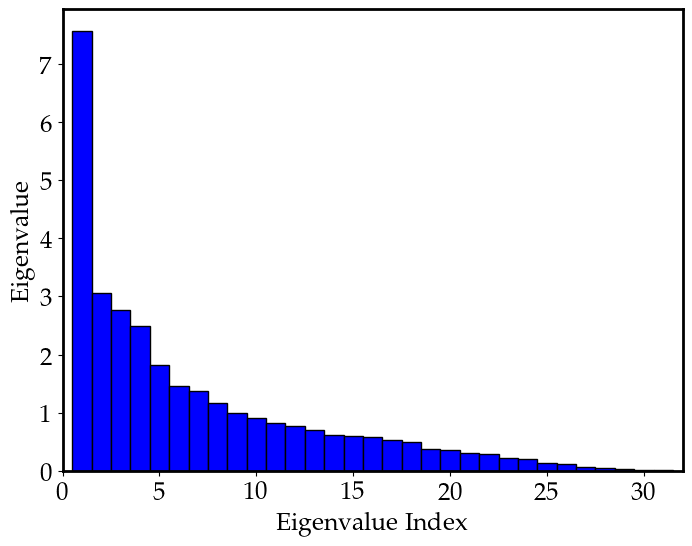

In [26]:
plt.figure(figsize=(8,6))
x = np.arange(1,32)
plt.xlim(0,32)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [27]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.2439071  0.09874688 0.08935272 0.08012538 0.05862037 0.04739842
 0.04431734 0.03769447 0.03214733 0.02948927 0.02656694 0.02482616
 0.02261654 0.02021431 0.01958498 0.01890891 0.01727722 0.01598865
 0.01236066 0.01192154 0.01016951 0.00970893 0.00699036 0.00668143
 0.00459365 0.00384461 0.00213751 0.0014366  0.00139616 0.00058447
 0.00039156]
[0.2439071  0.34265398 0.4320067  0.51213208 0.57075246 0.61815088
 0.66246822 0.70016269 0.73231001 0.76179928 0.78836622 0.81319238
 0.83580892 0.85602322 0.87560821 0.89451712 0.91179434 0.92778299
 0.94014365 0.9520652  0.96223471 0.97194364 0.978934   0.98561543
 0.99020908 0.99405369 0.9961912  0.99762781 0.99902397 0.99960844
 1.        ]
[5514.30493687 3508.65151564 3337.58591201 3160.55690981 2703.35349627
 2430.86313895 2350.52781702 2167.79072745 2001.93962896 1917.39054351
 1819.90753037 1759.27331913 1679.15811378 1587.4789053  1562.57241364
 1535.36562421 1467.62649182 1411.83684621 1241.36455575 1219.11532964
 1125.97474825 1100.

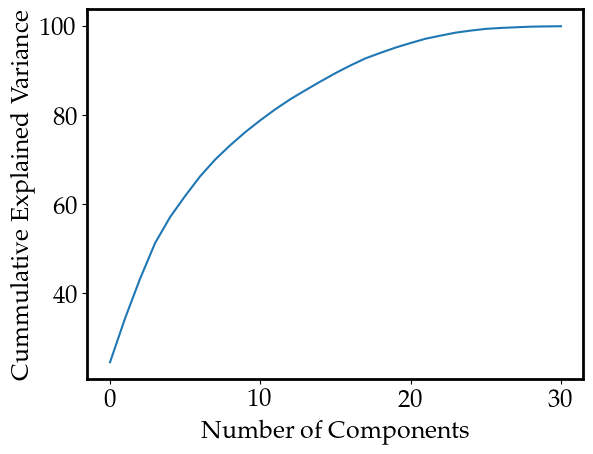

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [31]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [32]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/31 [00:00<?, ?it/s]

fj_tau21                         2.229428
fj_trackSip2dSigAboveBottom_0    1.358813
fj_trackSip2dSigAboveCharm_0     1.167742
fj_trackSip2dSigAboveBottom_1    1.046019
fj_tau_flightDistance2dSig_0     0.923719
fj_tau_vertexEnergyRatio_0       0.754299
fj_trackSipdSig_0                0.747068
fj_nSV                           0.703442
fj_trackSipdSig_0_0              0.638119
fj_tau_vertexDeltaR_0            0.596080
fj_tau_vertexEnergyRatio_1       0.594887
fj_trackSipdSig_1                0.586385
fj_tau1                          0.562591
fj_trackSipdSig_2                0.558224
fj_tau0_trackEtaRel_1            0.488746
fj_tau0_trackEtaRel_0            0.488517
fj_trackSipdSig_0_1              0.487035
fj_tau_flightDistance2dSig_1     0.449286
fj_tau1_trackEtaRel_1            0.440444
fj_tau1_trackEtaRel_0            0.438524
fj_trackSipdSig_1_0              0.405085
fj_trackSipdSig_3                0.365126
fj_tau1_trackEtaRel_2            0.313068
fj_tau3                          0

In [ ]:
X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:15]
X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:15]

In [33]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.close()
    return fig

In [137]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(Dense(units=62,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=62,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 62)                992       
                                                                 
 dense_4 (Dense)             (None, 62)                3906      
                                                                 
 dense_5 (Dense)             (None, 2)                 126       
                                                                 
Total params: 5,024
Trainable params: 5,024
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
losses = []
rates = np.logspace(-5,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**14, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9268 - accuracy: 0.4812
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9220 - accuracy: 0.4812
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9173 - accuracy: 0.4811
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9127 - accuracy: 0.4810
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9081 - accuracy: 0.4809
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9037 - accuracy: 0.4809
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8992 - accuracy: 0.4808
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8949 - accuracy: 0.4808
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8906 - accuracy: 0.4807
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8863 - accuracy: 0.4807

Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8366 - accuracy: 0.4811
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8151 - accuracy: 0.4825
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7955 - accuracy: 0.4848
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7775 - accuracy: 0.4882
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7610 - accuracy: 0.4926
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7459 - accuracy: 0.4979
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7320 - accuracy: 0.5039
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.9124 - accuracy: 0.4810
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8810 - accuracy: 0.4807
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8527 - accuracy: 0.4807

Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5450 - accuracy: 0.7765
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5291 - accuracy: 0.7845
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5156 - accuracy: 0.7902
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5040 - accuracy: 0.7949
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.8388 - accuracy: 0.4829
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.7173 - accuracy: 0.5139
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.6489 - accuracy: 0.5808
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.6054 - accuracy: 0.7092
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5745 - accuracy: 0.7544
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5509 - accuracy: 0.7729

Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3549 - accuracy: 0.8472
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6451
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.7985
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4448 - accuracy: 0.8151
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4163 - accuracy: 0.8236
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3964 - accuracy: 0.8294
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3816 - accuracy: 0.8344
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3703 - accuracy: 0.8393
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3615 - accuracy: 0.8437
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3547 - accuracy: 0.8474

Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3276 - accuracy: 0.8603
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3139 - accuracy: 0.8671
Epoch 5/10
246/246 [==============================] - 1s 5ms/step - loss: 0.3038 - accuracy: 0.8721
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2962 - accuracy: 0.8759
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2903 - accuracy: 0.8786
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2859 - accuracy: 0.8806
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2825 - accuracy: 0.8821
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2798 - accuracy: 0.8834
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4486 - accuracy: 0.7986
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3448 - accuracy: 0.8521

Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2592 - accuracy: 0.8928
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2570 - accuracy: 0.8938
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2551 - accuracy: 0.8947
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2535 - accuracy: 0.8954
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2521 - accuracy: 0.8960
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3344 - accuracy: 0.8568
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2779 - accuracy: 0.8842
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2686 - accuracy: 0.8884
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2637 - accuracy: 0.8906
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2603 - accuracy: 0.8923

Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2413 - accuracy: 0.9010
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2406 - accuracy: 0.9014
Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2945 - accuracy: 0.8754
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2592 - accuracy: 0.8927
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2526 - accuracy: 0.8958
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2488 - accuracy: 0.8976
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2464 - accuracy: 0.8988
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2445 - accuracy: 0.8996
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2432 - accuracy: 0.9002
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2421 - accuracy: 0.9006

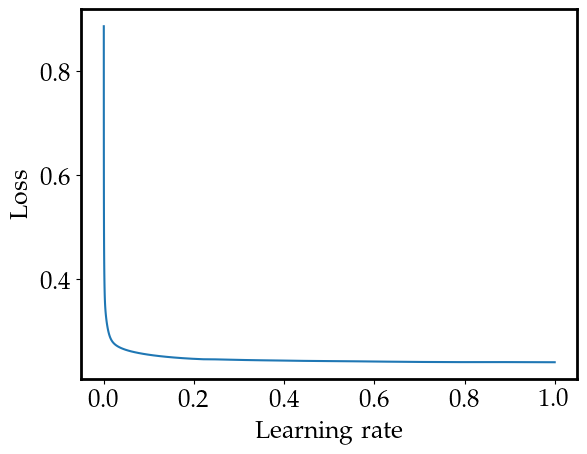

In [163]:
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [264]:
lr = rates[np.nanargmin(losses)]
print(lr)

1.0


In [268]:
%%time
# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**14, 
                          epochs=100)

Epoch 1/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2953 - accuracy: 0.8754
Epoch 2/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2584 - accuracy: 0.8930
Epoch 3/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2522 - accuracy: 0.8960
Epoch 4/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2485 - accuracy: 0.8977
Epoch 5/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2455 - accuracy: 0.8990
Epoch 6/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2447 - accuracy: 0.8994
Epoch 7/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2430 - accuracy: 0.9002
Epoch 8/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2420 - accuracy: 0.9007
Epoch 9/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2408 - accuracy: 0.9011
Epoch 10/100
246/246 [==============================] - 1s 4ms/step - loss: 0.2406 - accura

In [269]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 255us/step


In [270]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

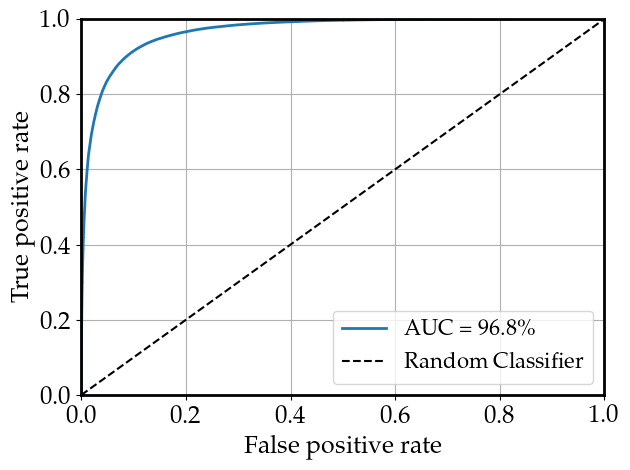

In [271]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC.pdf')
plt.show()

In [272]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS.pdf')

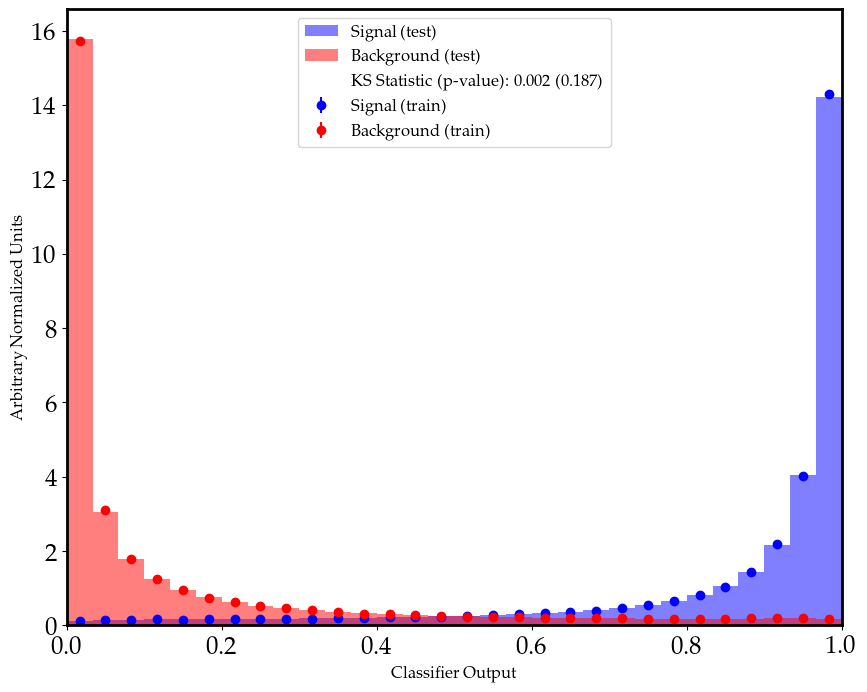

In [273]:
fig

In [274]:
bdt = XGBClassifier(booster='gbtree')

In [275]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 51min 39s, sys: 1min 57s, total: 53min 37s
Wall time: 6min 12s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [280]:
bdt.score(X_train_final.to_numpy(), y_train.to_numpy())

0.8977373999395261

In [281]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

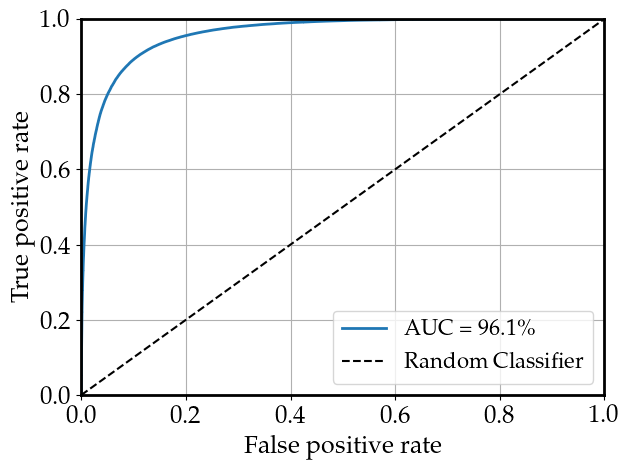

In [282]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC.pdf')
plt.show()

In [283]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS.pdf')

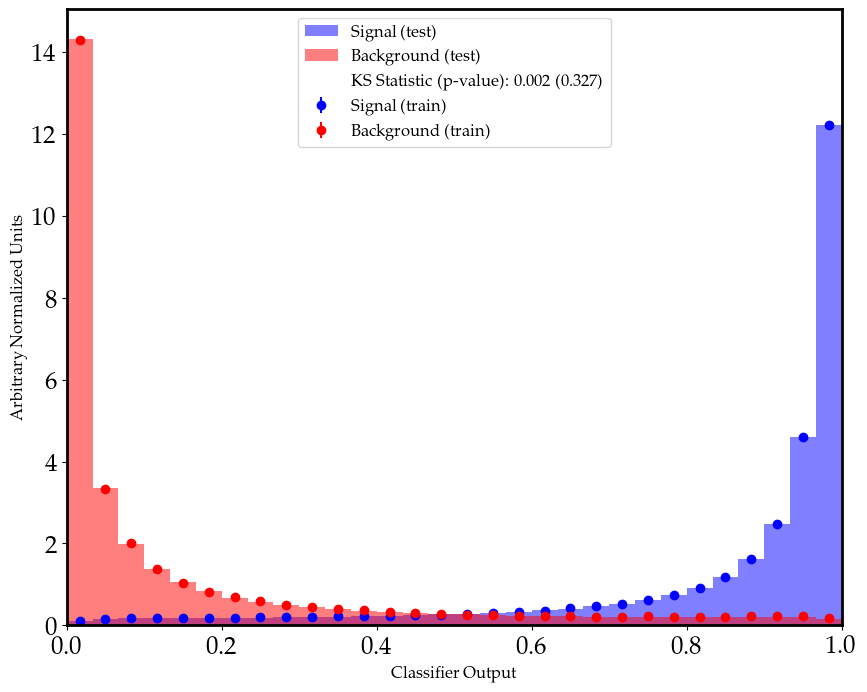

In [284]:
fig

In [285]:
fisher = LinearDiscriminantAnalysis()

In [286]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 5.25 s, sys: 1.18 s, total: 6.43 s
Wall time: 4.33 s


LinearDiscriminantAnalysis()

In [287]:
fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

0.8388767764215351

In [288]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

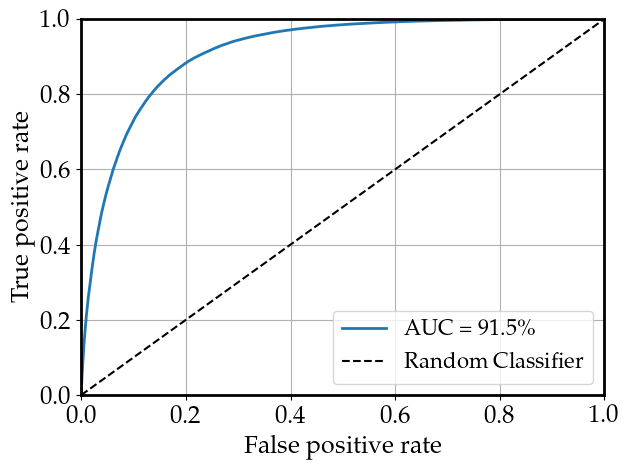

In [289]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC.pdf')
plt.show()

In [291]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS.pdf')

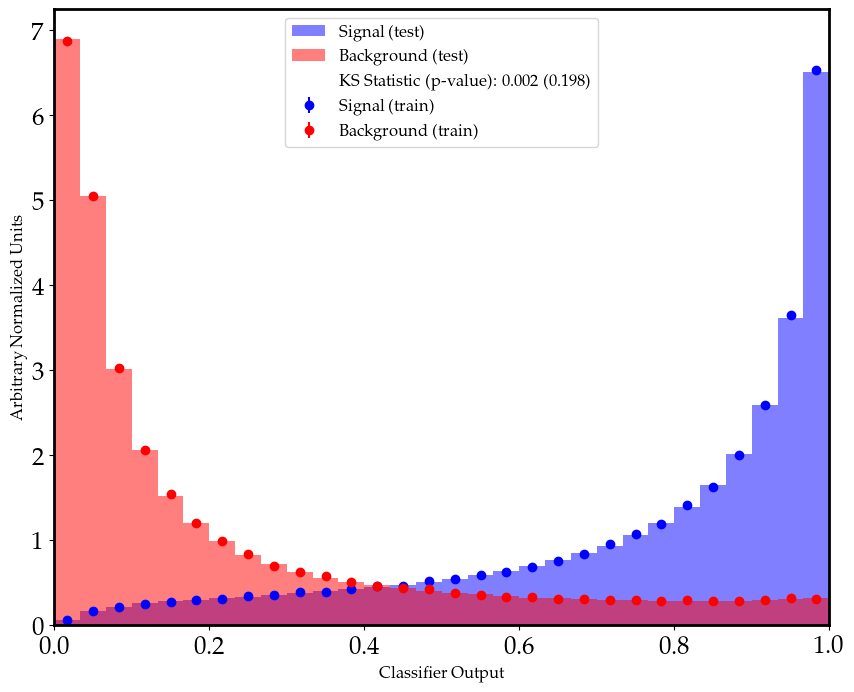

In [292]:
fig